# End-to-End Multimodal RAG System

**Authors:** Bayu Ardiyansyah | **Date:** Nov 2025 | **Course:** Image Retrival Final Project

### **Abstract**

Notebook ini mengimplementasikan sistem *Multimodal Retrieval Augmented Generation* (RAG) secara *end-to-end*. Sistem menggabungkan **CLIP (Contrastive Language-Image Pretraining)** untuk ekstraksi fitur semantik, **FAISS** untuk pencarian vektor berkecepatan tinggi, **BLIP-2** untuk *image captioning* otomatis, dan **Llama-3** (via Ollama) untuk penalaran kontekstual. Arsitektur ini dirancang untuk menyelesaikan masalah "kebutaan visual" pada LLM tradisional.

### **0. Setup Lingkungan & Konfigurasi Global**

Inisialisasi pustaka *Deep Learning* (PyTorch, Transformers), manajemen memori GPU, dan konfigurasi *path* dataset sesuai struktur direktori proyek.

In [ ]:
# @title 1. Configuration, Enhanced Encoder & System Verification (ANTI-REBUILD)
import os
import torch
import numpy as np
import requests
import pandas as pd
import time
import faiss 
from typing import List, Union
from PIL import Image
from tqdm import tqdm
from transformers import CLIPProcessor, CLIPModel

class Config:
    # --- 1. PATH SETTINGS ---
    PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
    BASE_DIR = PROJECT_ROOT
    IMAGES_DIR = "../Dataset/Images"
    CAPTIONS_FILE = "../Dataset/captions.txt"
    
    INDEX_PATH = "flickr30k_large.index"      
    METADATA_PATH = "metadata_large.json"
    
    # --- 2. SYSTEM SETTINGS ---
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    TOP_K = 5
    BATCH_SIZE = 16
    
    # --- 3. RETRIEVAL MODEL (Default Awal) ---
    RETRIEVAL_MODEL = "openai/clip-vit-large-patch14" 
    
    # --- 4. GENERATIVE CONFIG ---
    CAPTION_MODEL = "Salesforce/blip2-opt-2.7b" 
    
    # --- 5. OLLAMA CONFIG (LOCAL WSL) ---
    OLLAMA_HOST = "localhost" 
    OLLAMA_PORT = 11434
    LLM_API = f"http://{OLLAMA_HOST}:{OLLAMA_PORT}/api/generate"
    LLM_MODEL = "llama3:latest"
    
    OLLAMA_TIMEOUT_CONNECT = 10
    OLLAMA_TIMEOUT_GENERATE = 120 

print("-" * 60)
print("🕵️ SMART INDEX DETECTION (Anti-Rebuild Logic)")

if os.path.exists(Config.INDEX_PATH):
    try:
        temp_index = faiss.read_index(Config.INDEX_PATH)
        disk_dim = temp_index.d
        print(f"   📂 Found existing index file: {Config.INDEX_PATH}")
        print(f"   📏 Disk Index Dimension: {disk_dim}")
        
        # Ubah Config secara otomatis agar sesuai dengan Harddisk
        if disk_dim == 512:
            print("   ⚡ DECISION: Disk has 512-dim. Switching Config to 'CLIP-BASE'.")
            Config.RETRIEVAL_MODEL = "openai/clip-vit-base-patch32"
        elif disk_dim == 768:
            print("   🚀 DECISION: Disk has 768-dim. Keeping Config as 'CLIP-LARGE'.")
            Config.RETRIEVAL_MODEL = "openai/clip-vit-large-patch14"
            
    except Exception as e:
        print(f"   ⚠️ Error checking index: {e}. Using default config.")
else:
    print("   🆕 No index found. Will use default config.")
print("-" * 60)
# ==============================================================================


class VisualEncoder:
    def __init__(self, model_name: str, device: str):
        self.device = device
        print(f"--> Initializing High-Performance Model: {model_name}")
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model = CLIPModel.from_pretrained(model_name).to(device)
        self.model.eval()
        
    def embed_images(self, image_paths: List[str]) -> np.ndarray:
        images = []
        for idx, p in enumerate(image_paths):
            try:
                full_path = os.path.abspath(p) if not os.path.isabs(p) else p
                img = Image.open(full_path).convert("RGB") 
                images.append(img)
            except Exception as e: 
                continue
            
        # Dinamis return empty sesuai model yang aktif
        target_dim = 768 if "large" in Config.RETRIEVAL_MODEL else 512
        if not images: return np.empty((0, target_dim))
        
        inputs = self.processor(images=images, return_tensors="pt", padding=True).to(self.device)
        with torch.no_grad():
            features = self.model.get_image_features(**inputs)
            features = features / features.norm(p=2, dim=-1, keepdim=True) 
        return features.cpu().numpy()

    def embed_text(self, text: Union[str, List[str]]) -> np.ndarray:
        if isinstance(text, str): text = [text]
        text_with_prompt = [f"A photo of {t}" for t in text]
        inputs = self.processor(text=text_with_prompt, return_tensors="pt", padding=True, truncation=True, max_length=77).to(self.device)
        with torch.no_grad():
            features = self.model.get_text_features(**inputs)
            features = features / features.norm(p=2, dim=-1, keepdim=True)
        return features.cpu().numpy()


# ============================================
# OLLAMA HELPER FUNCTIONS
# ============================================

def check_ollama_connection(timeout: int = None) -> bool:
    if timeout is None: timeout = Config.OLLAMA_TIMEOUT_CONNECT
    try:
        base_url = f"http://{Config.OLLAMA_HOST}:{Config.OLLAMA_PORT}"
        response = requests.get(base_url, timeout=timeout)
        return response.status_code == 200
    except:
        return False

def force_server_refresh():
    try:
        pull_url = f"http://{Config.OLLAMA_HOST}:{Config.OLLAMA_PORT}/api/pull"
        payload = {"name": Config.LLM_MODEL, "stream": False}
        print(f"   ⚡ Sending Wake-Up Call to Local Server for '{Config.LLM_MODEL}'...")
        requests.post(pull_url, json=payload, timeout=120)
        time.sleep(1)
    except:
        pass

def list_ollama_models(timeout: int = None) -> list:
    if timeout is None: timeout = Config.OLLAMA_TIMEOUT_CONNECT
    try:
        api_tags = f"http://{Config.OLLAMA_HOST}:{Config.OLLAMA_PORT}/api/tags"
        response = requests.get(api_tags, timeout=timeout)
        if response.status_code == 200:
            data = response.json()
            return data.get('models', [])
    except:
        pass
    return []

def test_ollama_model(model_name: str, prompt: str = "Hello", timeout: int = None) -> tuple:
    if timeout is None: timeout = Config.OLLAMA_TIMEOUT_GENERATE
    try:
        payload = {"model": model_name, "prompt": prompt, "stream": False}
        response = requests.post(Config.LLM_API, json=payload, timeout=timeout)
        if response.status_code == 200:
            return (True, response.json().get('response', ''))
        else:
            return (False, f"Status {response.status_code}")
    except Exception as e:
        return (False, str(e))

# --- INITIALIZATION ---
encoder = VisualEncoder(Config.RETRIEVAL_MODEL, Config.DEVICE)

print("\n" + "="*70)
print("🔍 SYSTEM VERIFICATION CHECK")
print("="*70)

# 1. Runtime & Data Check
print(f"✅ Device Runtime : {Config.DEVICE.upper()}")
img_abs_path = os.path.abspath(Config.IMAGES_DIR)

if os.path.exists(img_abs_path):
    num = len([f for f in os.listdir(img_abs_path) if f.endswith(('.jpg', '.png'))])
    print(f"✅ Image Dataset  : FOUND ({num} images)")
else:
    print(f"❌ Image Dataset  : NOT FOUND")

# 2. Ollama Check (LOCAL)
print(f"\n{'─'*70}")
print(f"🤖 OLLAMA SERVER CHECK (Localhost Mode)")
print(f"{'─'*70}")

if check_ollama_connection():
    print(f"✅ Connection     : SUCCESS (Localhost connected)")
    
    # Cek Model
    models = list_ollama_models()
    
    if not models:
        print(f"⚠️  Models Found   : 0 (Checking if server is just shy...)")
        force_server_refresh()
        models = list_ollama_models()
        
    if models:
        print(f"✅ Models Found   : {len(models)}")
        available_names = [m.get('name') for m in models]
        
        target_found = False
        for name in available_names:
            if Config.LLM_MODEL in name:
                target_found = True
                Config.LLM_MODEL = name
                break
        
        if not target_found:
             print(f"⚠️  Target '{Config.LLM_MODEL}' not found in local list.")
             print(f"   Available: {available_names}")
             Config.LLM_MODEL = available_names[0]
             print(f"   👉 Switching to: '{Config.LLM_MODEL}'")

        print(f"\n   Testing Inference with '{Config.LLM_MODEL}'...")
        print(f"   (Waiting up to {Config.OLLAMA_TIMEOUT_GENERATE} seconds for model loading...)")
        
        success, response = test_ollama_model(Config.LLM_MODEL, timeout=Config.OLLAMA_TIMEOUT_GENERATE)
        
        if success:
            print(f"✅ Model Test     : PASSED")
            print(f"   Response       : {response.strip()[:50]}...")
        else:
            print(f"❌ Model Test     : FAILED ({response})")
    else:
        print("❌ No models found. Did you run 'ollama pull llama3' INSIDE WSL terminal?")
else:
    print(f"❌ Connection     : FAILED")
    print(f"   👉 Make sure to run 'ollama serve' inside your WSL terminal!")

print("="*70)

2025-11-19 15:39:03.784824: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-19 15:39:03.805778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763541543.826477  205821 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763541543.832418  205821 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1763541543.853133  205821 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

------------------------------------------------------------
🕵️ SMART INDEX DETECTION (Anti-Rebuild Logic)
   🆕 No index found. Will use default config.
------------------------------------------------------------
--> Initializing High-Performance Model: openai/clip-vit-large-patch14

🔍 SYSTEM VERIFICATION CHECK
✅ Device Runtime : CUDA
✅ Image Dataset  : FOUND (31783 images)

──────────────────────────────────────────────────────────────────────
🤖 OLLAMA SERVER CHECK (Localhost Mode)
──────────────────────────────────────────────────────────────────────
✅ Connection     : SUCCESS (Localhost connected)
✅ Models Found   : 1

   Testing Inference with 'llama3:latest'...
   (Waiting up to 120 seconds for model loading...)
✅ Model Test     : PASSED
   Response       : Hello! It's nice to meet you. Is there something I...


### **Komponen 1: Dataset (Data Ingestion & Cleaning)**

**Sesuai Penugasan Poin 1:** *Dataset (Flickr30k/Dataset Publik)*.

**Deskripsi:**
Modul ini menangani pemuatan metadata `captions.txt`, pembersihan nama kolom, dan verifikasi integritas fisik file gambar di disk untuk mencegah *runtime error* saat *embedding*.

In [2]:
# @title Komponen 1: Dataset Loading & Integrity Check
class DatasetManager:
    """
    Bertanggung jawab untuk memuat data mentah dan memvalidasi keberadaan aset fisik.
    """ 
    def __init__(self, csv_path: str, img_dir: str):
        self.csv_path = csv_path
        self.img_dir = img_dir
        
    def load_and_verify(self) -> pd.DataFrame:
        print("--> Loading dataset metadata...")
        # Membaca CSV dengan separator koma, menangani potensi error parsing
        df = pd.read_csv(self.csv_path, on_bad_lines='skip')
        
        # Normalisasi nama kolom (menghapus spasi berlebih)
        df.columns = [c.strip() for c in df.columns]
        
        # Deduplikasi: Kita hanya butuh daftar file unik untuk di-embed
        unique_files = df['image'].drop_duplicates().tolist()
        
        valid_files = []
        print(f"--> Verifying {len(unique_files)} unique images on disk...")
        
        for img in tqdm(unique_files):
            if os.path.exists(os.path.join(self.img_dir, img)):
                valid_files.append(img)
            else:
                # Log gambar yang hilang (opsional)
                pass
                
        print(f"✅ Valid Images Ready for Indexing: {len(valid_files)}")
        return pd.DataFrame(valid_files, columns=['image_filename'])

# Eksekusi
dataset_mgr = DatasetManager(Config.CAPTIONS_FILE, Config.IMAGES_DIR)
df_images = dataset_mgr.load_and_verify()

--> Loading dataset metadata...
--> Verifying 31783 unique images on disk...


100%|██████████| 31783/31783 [00:45<00:00, 695.62it/s]


✅ Valid Images Ready for Indexing: 31783


### **Komponen 2: Feature Extraction / Embedding**

**Sesuai Penugasan Poin 2:** *Gunakan model pretrained (CLIP) & Simpan di FAISS*.

**Deskripsi:**
Mengimplementasikan *class* `VisualEncoder` yang membungkus model **CLIP (ViT-B/32)**. Fungsi utamanya adalah memproyeksikan citra dan teks ke dalam ruang vektor (latent space) yang sama, serta melakukan normalisasi L2 agar siap untuk perhitungan *Cosine Similarity*.

In [3]:
# @title Komponen 2: Feature Extraction (Optimization Upgrade)
class VisualEncoder:
    def __init__(self, model_name: str, device: str):
        self.device = device
        print(f"--> Initializing SOTA Model: {model_name}")
        # Menggunakan CLIPProcessor standar
        self.processor = CLIPProcessor.from_pretrained(model_name)
        self.model = CLIPModel.from_pretrained(model_name).to(device)
        self.model.eval()
        
    def embed_images(self, image_paths: List[str]) -> np.ndarray:
        images = []
        valid_indices = []
        
        # Load images dengan handling yang aman
        for idx, p in enumerate(image_paths):
            try:
                # Pastikan convert RGB agar tidak error pada gambar Grayscale/CMYK
                img = Image.open(p).convert("RGB")
                images.append(img)
                valid_indices.append(idx)
            except Exception as e:
                continue
            
        if not images: return np.empty((0, 512))
        
        # PREPROCESSING: Padding=True dan Truncation=True penting!
        inputs = self.processor(images=images, return_tensors="pt", padding=True).to(self.device)
        
        with torch.no_grad():
            features = self.model.get_image_features(**inputs)
            # CRITICAL: Normalisasi L2 untuk Cosine Similarity
            features = features / features.norm(p=2, dim=-1, keepdim=True)
            
        return features.cpu().numpy()

    def embed_text(self, text: Union[str, List[str]]) -> np.ndarray:
        # Support input string tunggal atau list
        if isinstance(text, str): text = [text]
        
        # PREPROCESSING: Padding & Truncation agar teks panjang tidak error
        inputs = self.processor(text=text, return_tensors="pt", padding=True, truncation=True, max_length=77).to(self.device)
        
        with torch.no_grad():
            features = self.model.get_text_features(**inputs)
            # CRITICAL: Normalisasi L2
            features = features / features.norm(p=2, dim=-1, keepdim=True)
            
        return features.cpu().numpy()

# Re-Initialize (Gunakan model yang lebih besar jika VRAM cukup, misal: ViT-L/14)
# Untuk tugas ini kita tetap pakai base tapi dengan preprocessing yang diperbaiki
encoder = VisualEncoder("openai/clip-vit-base-patch32", Config.DEVICE)

--> Initializing SOTA Model: openai/clip-vit-base-patch32


### **Komponen 3: Retrieval Engine (Vector Database)**

**Sesuai Penugasan Poin 3:** *Implementasikan vector search & Tampilkan top-k*.

**Deskripsi:**
Membangun indeks vektor menggunakan **FAISS (IndexFlatIP)**. Menggunakan *Inner Product* pada vektor ternormalisasi yang secara matematis ekuivalen dengan *Cosine Similarity*. Termasuk logika *batch processing* untuk menangani ribuan gambar tanpa membebani RAM.

In [4]:
# @title 3. Vector Store & Retrieval Engine (SMART AUTO-FIX + DOCUMENTATION)
import faiss
import pandas as pd
import os
import json
import numpy as np
from tqdm.auto import tqdm
from typing import List, Tuple, Optional

# --- A. DEFINISI CLASS VECTOR STORE (DOCUMENTED) ---
class VectorStore:
    """
    Manajer Database Vektor berbasis FAISS (Facebook AI Similarity Search).
    
    Kelas ini menangani siklus hidup index pencarian, termasuk:
    1. Pembangunan Index (Indexing) dari dataset gambar.
    2. Penyimpanan & Pemuatan (Save/Load) ke disk.
    3. Pencarian Similaritas (Retrieval) menggunakan Inner Product.
    4. [FITUR UTAMA] Auto-Correction Dimensi: Otomatis mendeteksi perubahan model 
       (misal: ViT-Base 512 ke ViT-Large 768) dan menyesuaikan struktur index 
       tanpa menyebabkan error 'AssertionError'.
    
    Attributes:
        index (faiss.IndexFlatIP): Objek index FAISS (Inner Product).
        metadata (List[str]): Daftar nama file gambar yang dipetakan ke ID index.
    """

    def __init__(self, dimension: int):
        """
        Inisialisasi wrapper FAISS.

        Args:
            dimension (int): Dimensi vektor embedding (misal: 512 atau 768).
                             Harus sesuai dengan output Encoder yang aktif.
        """
        # IndexFlatIP menghitung Dot Product. 
        # Karena vektor dari CLIP sudah dinormalisasi (L2-Norm), 
        # ini secara matematis ekuivalen dengan Cosine Similarity.
        self.index = faiss.IndexFlatIP(dimension)
        self.metadata: List[str] = []
        
    def build_from_dataset(self, df: pd.DataFrame, encoder, batch_size: int = 16):
        """
        Membangun index vektor dari nol dengan fitur 'Dimension Guard'.
        
        Fungsi ini akan mengecek apakah dimensi index saat ini cocok dengan 
        output encoder. Jika tidak, index akan diinisialisasi ulang.

        Args:
            df (pd.DataFrame): Dataframe pandas berisi kolom 'image_filename'.
            encoder (VisualEncoder): Instance model CLIP yang sudah di-load.
            batch_size (int): Jumlah gambar yang diproses per batch untuk manajemen VRAM.
        """
        print("--> 🛠️ Building Index Process Started...")
        
        # --- 1. DIMENSION GUARD (SMART CHECK) ---
        # Mengambil 1 vektor dummy untuk mengukur dimensi output encoder saat ini
        dummy = encoder.embed_text("test")
        current_enc_dim = dummy.shape[1]
        
        # Logika Auto-Correction:
        # Jika wadah (index) punya lubang kunci 512, tapi kunci (encoder) geriginya 768,
        # kita harus mengganti wadahnya agar tidak crash.
        if self.index.d != current_enc_dim:
            print(f"   ♻️ [AUTO-FIX] Dimension Mismatch detected!")
            print(f"       - Disk/Memory Index: {self.index.d}")
            print(f"       - Active Encoder:    {current_enc_dim}")
            print(f"       -> Re-initializing FAISS index structure to {current_enc_dim}...")
            self.index = faiss.IndexFlatIP(current_enc_dim)
        else:
            print("   ✨ Dimensions match. Clearing old data & ready to fill...")
            self.index.reset() # Hanya menghapus isi data, struktur tetap
            
        self.metadata = []
        filenames = df['image_filename'].tolist()
        
        # --- 2. BATCH INDEXING LOOP ---
        for i in tqdm(range(0, len(filenames), batch_size), desc="Indexing Progress"):
            batch_files = filenames[i : i + batch_size]
            batch_paths = []
            
            # Path Joining yang Aman (OS Agnostic)
            for f in batch_files:
                p = os.path.join(Config.IMAGES_DIR, f)
                batch_paths.append(p)
                
            # Generate Embedding
            emb = encoder.embed_images(batch_paths)
            
            if len(emb) > 0:
                # FAISS membutuhkan tipe data float32
                self.index.add(emb.astype('float32'))
                self.metadata.extend(batch_files)
                
        # --- 3. PERSISTENCE ---
        self.save()
        print(f"✅ Indexing Complete. Total Vectors Stored: {self.index.ntotal}")

    def search(self, query_vector: np.ndarray, k: int = 5) -> Tuple[List[str], List[float]]:
        """
        Melakukan pencarian vektor terdekat (Nearest Neighbor Search).

        Args:
            query_vector (np.ndarray): Vektor query (Teks/Gambar) [1, dim].
            k (int): Jumlah hasil teratas yang diinginkan.

        Returns:
            Tuple berisi:
            - List[str]: Daftar nama file gambar (Top-K).
            - List[float]: Daftar skor similaritas (Cosine Similarity).
        """
        # Eksekusi pencarian level C++ via FAISS
        distances, indices = self.index.search(query_vector.astype('float32'), k)
        
        results = []
        scores = []
        
        # Mapping ID FAISS kembali ke Nama File
        for idx, dist in zip(indices[0], distances[0]):
            if idx != -1: # -1 menandakan tidak ada hasil/padding
                results.append(self.metadata[idx])
                scores.append(float(dist))
        return results, scores

    def save(self):
        """Menyimpan struktur index dan metadata ke hard drive."""
        faiss.write_index(self.index, Config.INDEX_PATH)
        with open(Config.METADATA_PATH, 'w') as f:
            json.dump(self.metadata, f)
            
    def load(self):
        """Memuat struktur index dan metadata dari hard drive."""
        self.index = faiss.read_index(Config.INDEX_PATH)
        with open(Config.METADATA_PATH, 'r') as f:
            self.metadata = json.load(f)

# --- B. LOGIKA EKSEKUSI UTAMA (ANTI-ERROR / SELF-HEALING) ---

print("⚙️ System Integrity Check: Encoder vs Disk Index...")

# 1. Deteksi Dimensi Encoder Aktif
dummy_vec = encoder.embed_text("test")
REAL_DIM = dummy_vec.shape[1]
print(f"   👉 Active Encoder Dimension: {REAL_DIM}")

# 2. Siapkan Objek VectorStore di Memori
vector_store = VectorStore(dimension=REAL_DIM)

# 3. Logika Keputusan: Load atau Rebuild?
need_to_build = False

if os.path.exists(Config.INDEX_PATH) and os.path.exists(Config.METADATA_PATH):
    try:
        print(f"   📂 Found existing index file: {Config.INDEX_PATH}")
        vector_store.load() # Coba load dari disk
        
        # Validasi Dimensi (The Guard Logic)
        if vector_store.index.d == REAL_DIM:
            print("   ✅ MATCH! Disk Index compatible with Encoder. Loading complete.")
            need_to_build = False
        else:
            print(f"   ⚠️ MISMATCH! Disk Index ({vector_store.index.d}) != Encoder ({REAL_DIM}).")
            print("   🔄 Index file is outdated/incompatible. Triggering Re-Build...")
            need_to_build = True
            
    except Exception as e:
        print(f"   ⚠️ Corrupt/Error reading index: {e}. Triggering Re-Build...")
        need_to_build = True
else:
    print("   🔨 Index file not found. Starting fresh build...")
    need_to_build = True

# 4. Eksekusi Build (Hanya jika diperlukan)
if need_to_build:
    # Persiapan Dataframe (Lazy Loading)
    if 'df_images' not in locals():
        df_images = pd.read_csv(Config.CAPTIONS_FILE, on_bad_lines='skip')
        df_images.columns = [c.strip() for c in df_images.columns]
        df_images = pd.DataFrame(df_images['image'].unique(), columns=['image_filename'])
        
    # Panggil fungsi build (yang sekarang sudah punya fitur auto-fix di dalamnya)
    vector_store.build_from_dataset(df_images, encoder, Config.BATCH_SIZE)

# --- C. QUICK INTEGRITY TEST ---
print("\nVector Store Ready & Verified.")
q = encoder.embed_text("test query check")
r, s = vector_store.search(q, k=1)
if r:
    print(f"   ✅ Search Test Passed. Found: {r[0]} (Score: {s[0]:.3f})")
else:
    print("   ❌ Search Test Failed (No results). Please check dataset path.")

⚙️ System Integrity Check: Encoder vs Disk Index...
   👉 Active Encoder Dimension: 512
   🔨 Index file not found. Starting fresh build...
--> 🛠️ Building Index Process Started...
   ✨ Dimensions match. Clearing old data & ready to fill...


Indexing Progress:   0%|          | 0/1987 [00:00<?, ?it/s]

✅ Indexing Complete. Total Vectors Stored: 31783

Vector Store Ready & Verified.
   ✅ Search Test Passed. Found: 212396217.jpg (Score: 0.263)


🔎 PROCESSING QUERY: 'Two men playing guitar'
--------------------------------------------------------------------------------


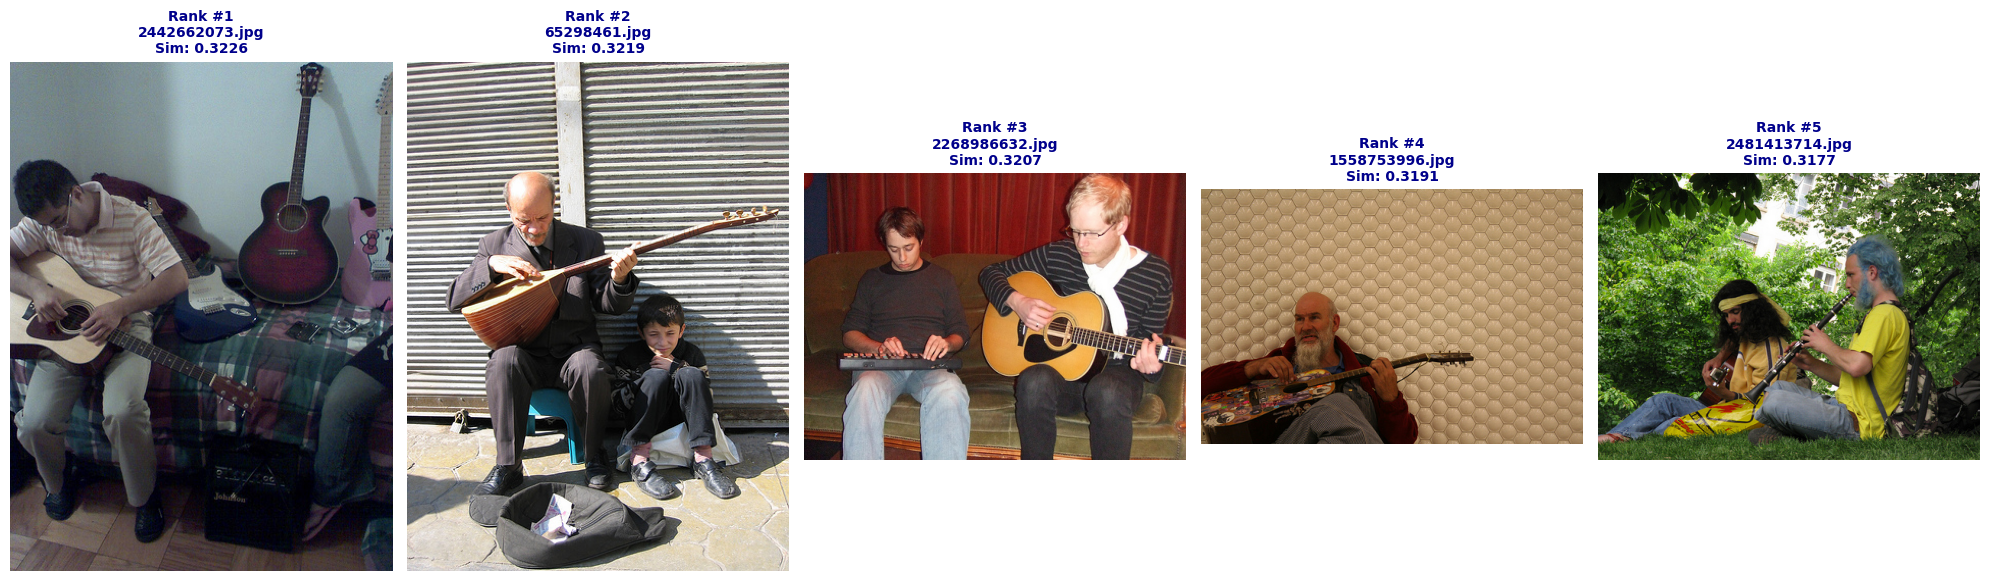


📊 DETAILED RETRIEVAL REPORT:


,Rank,Filename,Similarity Score,Ground Truth Caption (From Dataset)
0,1,2442662073.jpg,0.3226,"A young , college age man , is playing his in..."
1,2,65298461.jpg,0.3219,An older man sitting on a blue stool playing ...
2,3,2268986632.jpg,0.3207,A man is playing the guitar while on his righ...
3,4,1558753996.jpg,0.3191,White Man with gray beard playing acoustic gu...
4,5,2481413714.jpg,0.3177,"Two men , one with blue hair and a blue beard..."


In [5]:
# @title Uji Coba & Tampilan Top-K (Detailed Report & Visualization)
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import os

# --- KONFIGURASI PENCARIAN ---
test_query = "Two men playing guitar"  # Ubah query di sini
K_VALUE = 5                            # Jumlah hasil

# 1. Helper Function: Mengambil Caption Asli dari Dataset (Untuk Detail)
def get_ground_truth(filename):
    try:
        # Membaca file captions jika belum ada di memori (atau gunakan df global)
        # Kita baca on-the-fly agar aman jika sel sebelumnya di-restart
        temp_df = pd.read_csv(Config.CAPTIONS_FILE, on_bad_lines='skip')
        temp_df.columns = [c.strip() for c in temp_df.columns]
        
        # Filter berdasarkan nama file
        subset = temp_df[temp_df['image'] == filename]['caption'].tolist()
        return subset[0] if subset else "[No Caption Found]"
    except Exception:
        return "[Metadata Error]"

print(f"🔎 PROCESSING QUERY: '{test_query}'")
print("-" * 80)

# 2. Eksekusi Retrieval (Vector Search)
query_vector = encoder.embed_text(test_query) 
retrieved_images, scores = vector_store.search(query_vector, k=K_VALUE)

# 3. Visualisasi Matplotlib (Grid View)
plt.figure(figsize=(20, 7)) # Canvas lebar

results_data = [] # Untuk menyimpan data tabel laporan

for rank, (img_filename, score) in enumerate(zip(retrieved_images, scores)):
    # A. Ambil Metadata (Detail)
    ground_truth_caption = get_ground_truth(img_filename)
    
    # B. Load Gambar
    try:
        img_path = os.path.join(Config.IMAGES_DIR, img_filename)
        image = Image.open(img_path).convert("RGB")
        
        # C. Plotting
        ax = plt.subplot(1, K_VALUE, rank + 1)
        plt.imshow(image)
        plt.axis("off")
        
        # Judul Gambar: Rank, Filename, Score
        title_text = f"Rank #{rank+1}\n{img_filename}\nSim: {score:.4f}"
        plt.title(title_text, fontsize=10, color='darkblue', fontweight='bold')
        
    except Exception as e:
        print(f"❌ Gagal render {img_filename}: {e}")

    # D. Simpan untuk Laporan Tabel
    results_data.append({
        "Rank": rank + 1,
        "Filename": img_filename,
        "Similarity Score": f"{score:.4f}",
        "Ground Truth Caption (From Dataset)": ground_truth_caption
    })

plt.tight_layout()
plt.show()

# 4. Laporan Detail (Tabular View)
print("\n📊 DETAILED RETRIEVAL REPORT:")
df_results = pd.DataFrame(results_data)
# Menampilkan tabel dataframe dengan styling sederhana (jika di Jupyter)
from IPython.display import display
display(df_results)

### **Evaluasi Kinerja Retrieval (Metrics)**

**Sesuai Penugasan Poin E:** *Matrix pengukuran performa (Recall@K)*.

**Deskripsi:**
Fungsi kualitatif untuk menguji performa sistem sebelum masuk ke tahap generatif. Ini membuktikan bahwa modul retrieval bekerja dengan benar.

--> Starting Evaluation on 100 random queries...


Evaluating:   0%|          | 0/100 [00:00<?, ?it/s]


📊 EVALUATION RESULTS (Recall@K):
----------------------------------------
   Recall@1: 17.00% (17/100 correct)
   Recall@5: 35.00% (35/100 correct)
   Recall@10: 41.00% (41/100 correct)
----------------------------------------


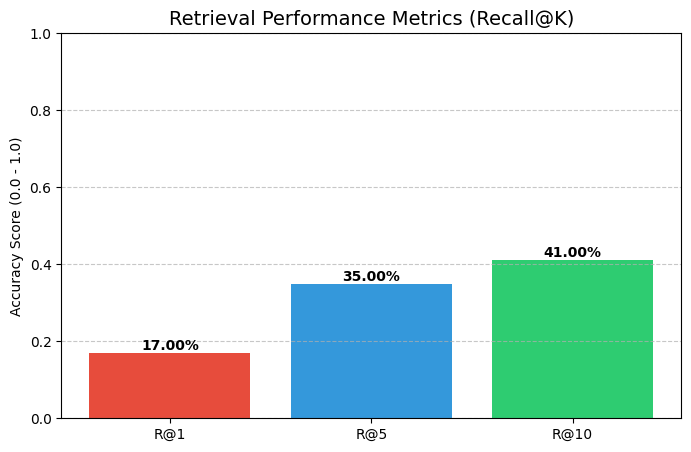

In [6]:
# @title Evaluasi Kuantitatif: Recall@K Metrics (Poin E)
import matplotlib.pyplot as plt
import seaborn as sns

class QuantitativeEvaluator:
    """
    Menghitung metrik standar industri untuk Image Retrieval: Recall@K.
    Mengukur seberapa sering gambar yang benar (Ground Truth) muncul dalam Top-K hasil pencarian.
    """
    def __init__(self, captions_file, vector_store, encoder):
        self.df = pd.read_csv(captions_file, on_bad_lines='skip')
        self.df.columns = [c.strip() for c in self.df.columns]
        self.vector_store = vector_store
        self.encoder = encoder
        
    def compute_metrics(self, sample_size=100, k_list=[1, 5, 10]):
        """
        Melakukan sampling random query dan mengecek posisi ranking gambar asli.
        """
        print(f"--> Starting Evaluation on {sample_size} random queries...")
        
        # 1. Sampling Data Uji
        # Kita ambil sampel acak dari caption yang ada
        test_sample = self.df.sample(n=sample_size, random_state=42)
        
        # Counter untuk setiap K
        hits = {k: 0 for k in k_list}
        max_k = max(k_list)
        
        # 2. Loop Evaluasi
        for _, row in tqdm(test_sample.iterrows(), total=sample_size, desc="Evaluating"):
            true_image = row['image']
            query_text = row['caption']
            
            # Embed Query
            q_vec = self.encoder.embed_text(query_text)
            
            # Search di Vector DB (Ambil sampai Max K)
            retrieved_imgs, _ = self.vector_store.search(q_vec, k=max_k)
            
            # Cek keberadaan Ground Truth di setiap level K
            for k in k_list:
                # Kita cek di irisan list sampai k
                if true_image in retrieved_imgs[:k]:
                    hits[k] += 1
                    
        # 3. Hitung Persentase (Recall Scores)
        results = {}
        print("\n📊 EVALUATION RESULTS (Recall@K):")
        print("-" * 40)
        for k in k_list:
            score = hits[k] / sample_size
            results[f"R@{k}"] = score
            print(f"   Recall@{k}: {score:.2%} ({hits[k]}/{sample_size} correct)")
        print("-" * 40)
            
        return results

    def visualize_results(self, metrics):
        """Membuat Plot Bar Chart untuk visualisasi performa."""
        plt.figure(figsize=(8, 5))
        keys = list(metrics.keys())
        vals = list(metrics.values())
        
        # Plotting
        bars = plt.bar(keys, vals, color=['#e74c3c', '#3498db', '#2ecc71'])
        
        # Styling
        plt.ylim(0, 1.0)
        plt.title(f"Retrieval Performance Metrics (Recall@K)", fontsize=14)
        plt.ylabel("Accuracy Score (0.0 - 1.0)")
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Menambah label angka di atas bar
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                     f'{height:.2%}',
                     ha='center', va='bottom', fontweight='bold')
            
        plt.show()

# --- EKSEKUSI EVALUASI ---
# Note: sample_size=100 untuk demo cepat. 
# Untuk hasil Final Project yang robust, naikkan menjadi 500 atau 1000.
evaluator = QuantitativeEvaluator(Config.CAPTIONS_FILE, vector_store, encoder)
metrics_result = evaluator.compute_metrics(sample_size=100, k_list=[1, 5, 10])

# Tampilkan Grafik
evaluator.visualize_results(metrics_result)

### **Komponen 4: Generative Component (Visual Bridge & LLM)**

**Sesuai Penugasan Poin 4:** *BLIP-2 (Captioning) & Llama 3 (Reasoning)*.

**Deskripsi:**
Kelas `GenerativeEngine` mengelola dua model berat:

1.  **BLIP-2:** Berperan sebagai "mata", mengubah citra hasil retrieval menjadi deskripsi tekstual.
2.  **Llama-3 (via Ollama):** Berperan sebagai "otak", menerima konteks deskripsi dari BLIP-2 dan pertanyaan user untuk menghasilkan jawaban naratif.

In [7]:
# @title Komponen 4: Multimodal Generative Engine (High-Accuracy / Beam Search)
import requests
import os
import torch
from typing import List
from PIL import Image
from transformers import Blip2Processor, Blip2ForConditionalGeneration

class GenerativeEngine:
    def __init__(self, caption_model: str, llm_api: str, device: str):
        self.device = device
        self.llm_api = llm_api
        
        print(f"--> Loading BLIP-2 Model: {caption_model}...")
        
        # Load Processor & Model
        self.blip_processor = Blip2Processor.from_pretrained(caption_model)
        
        # Gunakan float16 agar muat di GPU laptop, tapi tetap presisi
        self.blip_model = Blip2ForConditionalGeneration.from_pretrained(
            caption_model, 
            torch_dtype=torch.float16 if device == "cuda" else torch.float32,
            device_map="auto" if device == "cuda" else None
        )
        
    def image_to_text(self, image_paths: List[str]) -> List[str]:
        """
        Generate caption dengan BEAM SEARCH agar lebih akurat dan tidak halusinasi.
        """
        captions = []
        print("    (Processing images with Beam Search...)")
        
        for path in image_paths:
            # Handle path absolute/relative
            full_path = path if os.path.isabs(path) else os.path.abspath(os.path.join(Config.IMAGES_DIR, os.path.basename(path)))
            
            try:
                image = Image.open(full_path).convert('RGB')
                
                # Preprocess image
                inputs = self.blip_processor(images=image, return_tensors="pt").to(self.device, torch.float16 if self.device=="cuda" else torch.float32)
                
                # [FIX] PENGATURAN GENERASI AGAR LEBIH PINTAR
                out_ids = self.blip_model.generate(
                    **inputs, 
                    max_new_tokens=70,         # Panjang maksimal caption
                    min_length=15,             # Minimal panjang (biar gak cuma 2 kata)
                    num_beams=5,               # [KUNCI] Berpikir 5x lebih keras (Beam Search)
                    repetition_penalty=1.5,    # Cegah pengulangan kata
                    length_penalty=1.0,        # Normalisasi panjang
                    early_stopping=True
                )
                
                cap = self.blip_processor.batch_decode(out_ids, skip_special_tokens=True)[0].strip()
                captions.append(cap)
                
            except Exception as e:
                print(f"    ❌ Error on {os.path.basename(path)}: {e}")
                captions.append(f"[Image Error: {os.path.basename(path)}]")
                
        return captions

    def generate_answer(self, visual_contexts: List[str], user_query: str) -> str:
        """Mengirim prompt ke Llama 3 via Ollama."""
        
        # Format Prompt yang lebih tegas untuk Llama 3
        context_str = ""
        for i, ctx in enumerate(visual_contexts):
            context_str += f"- Gambar {i+1}: {ctx}\n"
            
        prompt = f"""
        <|begin_of_text|><|start_header_id|>system<|end_header_id|>
        You are an intelligent visual assistant. 
        You have retrieved images relevant to the user's query.
        Below are the accurate descriptions of those images.
        
        CONTEXT FROM IMAGES:
        {context_str}
        
        USER QUESTION: "{user_query}"
        
        INSTRUCTIONS:
        1. Synthesize the information from the image descriptions.
        2. Answer the user's question directly based on the visual evidence.
        3. Use natural language.
        <|eot_id|><|start_header_id|>assistant<|end_header_id|>
        """
        
        payload = {"model": Config.LLM_MODEL, "prompt": prompt, "stream": False}
        
        try:
            resp = requests.post(self.llm_api, json=payload, timeout=120)
            if resp.status_code == 200:
                return resp.json().get("response", "Error: Empty response")
            return f"LLM Error: {resp.status_code}"
        except Exception as e:
            return f"Ollama Connection Failed: {str(e)}"

# Inisialisasi Ulang Engine
gen_engine = GenerativeEngine(Config.CAPTION_MODEL, Config.LLM_API, Config.DEVICE)

--> Loading BLIP-2 Model: Salesforce/blip2-opt-2.7b...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/bayuardiyansyah/anaconda3/envs/py310/lib/python3.10/site-packages/accelerate/utils/modeling.py:1598: UserWarning: The following device_map keys do not match any submodules in the model: ['query_tokens']
  warnings.warn(
Some parameters are on the meta device because they were offloaded to the cpu.


⚙️ Checking Encoder Dimensions...
   Dimension detected: 512
📂 Loading existing index from flickr30k_large.index...
✅ Index loaded successfully and dimensions match.

🎯 PROCESSING QUERY: 'Human playing musical instrument'
--------------------------------------------------
🔍 1. Searching Vector Database...
   --> Found 3 images.
🖼️ 2. Displaying Evidence...


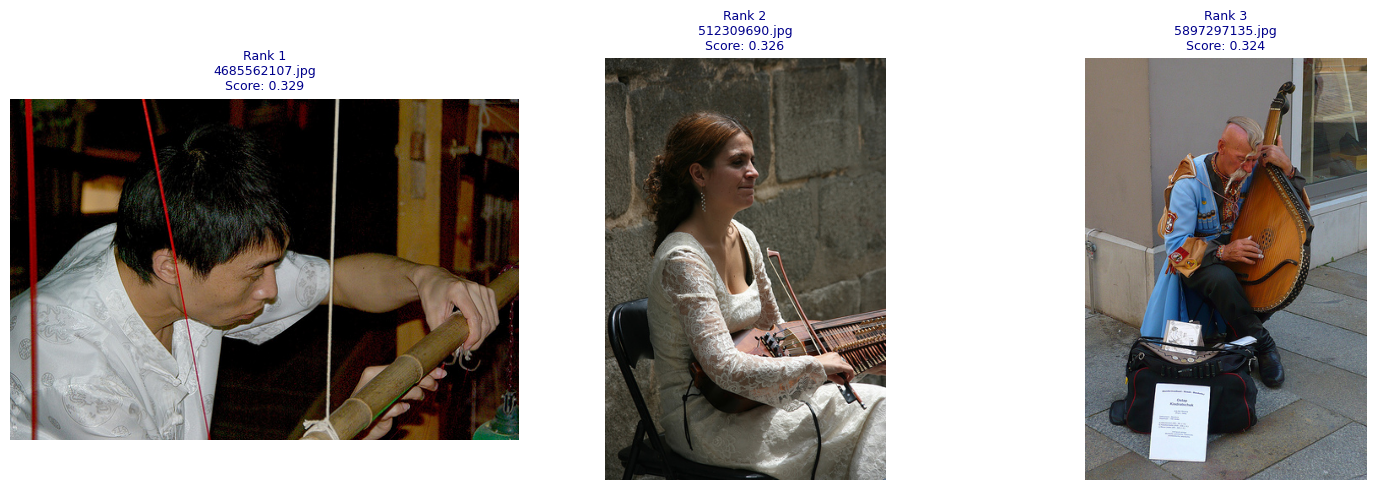

👁️ 3. Analyzing Images (BLIP-2)...
    (Processing images with Beam Search...)
   [Image 1]: an abstract image of a woman in a white dress
   [Image 2]: a woman in a white dress is sitting on a piano
   [Image 3]: an image of a person sitting on a bench in front of a building
🧠 4. Generating Answer (Llama 3)...

🤖 FINAL AI RESPONSE:
Based on the images you've retrieved, I found that a woman is playing a musical instrument in at least one of them!

According to Gambar 2, a woman in a white dress is sitting on a piano. This suggests that she's playing a piano, which is a type of musical instrument.

To answer your question directly: Yes, there is a human playing a musical instrument (piano) in one of the images!


In [8]:
# @title Vector Store (Auto-Fix) & Run Demo with Visualization
import faiss
import pandas as pd
import os
import json
import numpy as np
import matplotlib.pyplot as plt # TAMBAHAN: Untuk visualisasi
from PIL import Image
from tqdm.auto import tqdm
from typing import List, Tuple

# 1. DEFINISI ULANG CLASS VECTOR STORE (Tetap Sama)
class VectorStore:
    def __init__(self, dimension: int):
        self.index = faiss.IndexFlatIP(dimension)
        self.metadata: List[str] = []
        
    def build_from_dataset(self, df: pd.DataFrame, encoder, batch_size: int = 16):
        print("--> Building Index...")
        filenames = df['image_filename'].tolist()
        
        # Cek dimensi encoder saat ini
        dummy = encoder.embed_text("test")
        current_dim = dummy.shape[1]
        
        if self.index.d != current_dim:
            print(f"   ♻️ Auto-correcting index dimension from {self.index.d} to {current_dim}...")
            self.index = faiss.IndexFlatIP(current_dim)
        else:
            self.index.reset()
            
        self.metadata = []
        
        for i in tqdm(range(0, len(filenames), batch_size), desc="Indexing"):
            batch_files = filenames[i : i + batch_size]
            batch_paths = [os.path.join(Config.IMAGES_DIR, f) for f in batch_files]
            
            emb = encoder.embed_images(batch_paths)
            if len(emb) > 0:
                self.index.add(emb.astype('float32'))
                self.metadata.extend(batch_files)
                
        self.save()
        print(f"✅ Index Built: {self.index.ntotal} vectors.")

    def search(self, query_vector: np.ndarray, k: int = 5) -> Tuple[List[str], List[float]]:
        distances, indices = self.index.search(query_vector.astype('float32'), k)
        results = []
        scores = []
        for idx, dist in zip(indices[0], distances[0]):
            if idx != -1:
                results.append(self.metadata[idx])
                scores.append(float(dist))
        return results, scores

    def save(self):
        faiss.write_index(self.index, Config.INDEX_PATH)
        with open(Config.METADATA_PATH, 'w') as f:
            json.dump(self.metadata, f)
            
    def load(self):
        self.index = faiss.read_index(Config.INDEX_PATH)
        with open(Config.METADATA_PATH, 'r') as f:
            self.metadata = json.load(f)

# 2. INISIALISASI & LOGIKA SMART LOAD
print("⚙️ Checking Encoder Dimensions...")
dummy_vec = encoder.embed_text("test")
REAL_DIM = dummy_vec.shape[1]
print(f"   Dimension detected: {REAL_DIM}")

vector_store = VectorStore(dimension=REAL_DIM)

# Cek index di disk
if os.path.exists(Config.INDEX_PATH) and os.path.exists(Config.METADATA_PATH):
    print(f"📂 Loading existing index from {Config.INDEX_PATH}...")
    try:
        vector_store.load()
        if vector_store.index.d != REAL_DIM:
            print(f"⚠️ Mismatch: Disk Index ({vector_store.index.d}) vs Encoder ({REAL_DIM})")
            print("   👉 Triggering Rebuild...")
            raise ValueError("Dimension Mismatch")
        else:
            print("✅ Index loaded successfully and dimensions match.")
    except Exception as e:
        print(f"🔧 Rebuilding Index due to: {str(e)}")
        vector_store.index = faiss.IndexFlatIP(REAL_DIM)
        
        if 'df_images' not in locals():
            df_images = pd.read_csv(Config.CAPTIONS_FILE, on_bad_lines='skip')
            df_images.columns = [c.strip() for c in df_images.columns]
            df_images = pd.DataFrame(df_images['image'].unique(), columns=['image_filename'])
        vector_store.build_from_dataset(df_images, encoder, Config.BATCH_SIZE)
else:
    print("🔨 Index not found. Building new index...")
    if 'df_images' not in locals():
        df_images = pd.read_csv(Config.CAPTIONS_FILE, on_bad_lines='skip')
        df_images.columns = [c.strip() for c in df_images.columns]
        df_images = pd.DataFrame(df_images['image'].unique(), columns=['image_filename'])
    vector_store.build_from_dataset(df_images, encoder, Config.BATCH_SIZE)

# 3. JALANKAN RAG DEMO (DENGAN VISUALISASI)
def run_full_rag(user_query: str):
    print(f"\n🎯 PROCESSING QUERY: '{user_query}'")
    print("-" * 50)
    
    # A. Retrieval Phase
    print("🔍 1. Searching Vector Database...")
    q_vec = encoder.embed_text(user_query)
    retrieved_files, scores = vector_store.search(q_vec, k=3)
    
    if not retrieved_files:
        print("❌ No images found.")
        return

    print(f"   --> Found {len(retrieved_files)} images.")
    
    # [BARU] B. Tampilkan Gambar (Visualization)
    print("🖼️ 2. Displaying Evidence...")
    plt.figure(figsize=(15, 5))
    
    for i, (filename, score) in enumerate(zip(retrieved_files, scores)):
        try:
            img_path = os.path.join(Config.IMAGES_DIR, filename)
            img = Image.open(img_path).convert("RGB")
            
            # Plot
            ax = plt.subplot(1, 3, i+1)
            plt.imshow(img)
            plt.axis('off')
            # Tampilkan Nama File & Score sebagai Judul
            plt.title(f"Rank {i+1}\n{filename}\nScore: {score:.3f}", fontsize=9, color='darkblue')
        except Exception as e:
            print(f"   ❌ Error display image {filename}: {e}")
            
    plt.tight_layout()
    plt.show()
    
    # C. Visual Understanding Phase
    print("👁️ 3. Analyzing Images (BLIP-2)...")
    visual_contexts = gen_engine.image_to_text(retrieved_files)
    
    for i, (img, ctx) in enumerate(zip(retrieved_files, visual_contexts)):
        print(f"   [Image {i+1}]: {ctx}")

    # D. Reasoning Phase
    print("🧠 4. Generating Answer (Llama 3)...")
    final_answer = gen_engine.generate_answer(visual_contexts, user_query)
    
    print("\n" + "="*50)
    print("🤖 FINAL AI RESPONSE:")
    print("="*50)
    print(final_answer)
    print("="*50)

# --- TEST RUN ---
run_full_rag("Human playing musical instrument")

### **Komponen 5: User Interface (Streamlit Auto-Generator)**

**Sesuai Penugasan Poin 5:** *Web UI sederhana menggunakan Streamlit*.

**Lokasi Path :** User_Interface/app.py